In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd 
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.datasets import ImageFolder
import torch.optim as optim
import torch.nn as nn

# Ignore warnings 
import warnings 
warnings.filterwarnings('ignore') 

# Import pathlib
from pathlib import Path

# Interactive mode on 
plt.ion() 

In [30]:
from torch import cuda

cuda.set_device(0)
current_dev = cuda.current_device()
current_dev_name = cuda.get_device_name(current_dev)
current_dev_specs = cuda.get_device_properties(current_dev)

print(f'Current Device: {current_dev}')
print(f'Current Device Name: {current_dev_name}')
print(f'Current Device Specs: {current_dev_specs}')

Current Device: 1
Current Device Name: TITAN V
Current Device Specs: _CudaDeviceProperties(name='TITAN V', major=7, minor=0, total_memory=12066MB, multi_processor_count=80)


In [2]:
class HeatMapsDataset(Dataset):
    '''
    Dataset for network flow heatmaps
    Args:
        @root (Path): path to root directory for dataset  
        @transforms (callable, optional): transforms to be applied to data
    '''
    
    def __init__(self, root: Path, transform=None):
        self.root = root
        self.transform = transform
        self.classes = ['ddos_tcp', 'clean_tcp']
        self.images = []
        for dirent in self.classes:
            tmp = self.root / dirent
            self.images += [x for x in tmp.iterdir() if x.suffix.lower() == '.png']
            
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = io.imread(img_path)
        image = image[:23, :23, :3]
        
        label = str(self.images[idx].parents[0])
        label = label.split('/')[-1]
        
        sample = (image, label)
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

In [3]:
class ToTensor(object):
    '''
    Converts an image to a tensor
    Args:
        @sample (ndarray, string): image in the form of a numpy array and it's label 
    '''
    def __call__(self, sample):
        image, label = sample
        
        image = image.transpose((2, 0, 1))
        return (torch.from_numpy(image), label)

In [4]:
path = Path.cwd().parents[0] / 'data' / 'heat_maps'

composed = transforms.Compose([
    ToTensor()
])

data = HeatMapsDataset(path, transform=composed)

torch.Size([3, 23, 23])
(23, 23, 3)


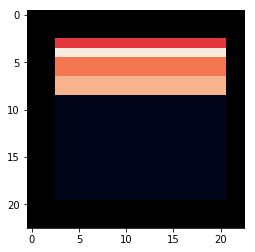

In [5]:
img = data[0][0]
print(img.shape)
img = img.numpy().transpose((1, 2, 0))
print(img.shape)
plt.imshow(img)

In [6]:
loader = DataLoader(data, batch_size=4, num_workers=4)

In [7]:
def showBatch(batch):
    '''Show a batch of images and their labels'''
    
    image_batch, label_batch = batch
    batch_size = len(image_batch)
    grid_border_size = 2
    
    grid = utils.make_grid(image_batch)
    
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    
    for label in label_batch:
        print(label, end='\t')
    print()
    
    plt.title('Batch from dataloader')

clean_tcp	clean_tcp	clean_tcp	clean_tcp	


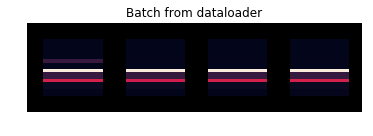

In [8]:
for i_batch, sample_batched in enumerate(loader):
    img, label = sample_batched
    
    if i_batch == 23:
        plt.figure()
        showBatch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [3]:
model = torch.hub.load('pytorch/vision:v0.4.2', 'mobilenet_v2', pretrained=False, num_classes=2)
model.to('cuda')

Using cache found in /home/SGF.EDUBEAR.NET/eam96/.cache/torch/hub/pytorch_vision_v0.4.2


MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [4]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

img_set = ImageFolder(path, transform=preprocess)

NameError: name 'path' is not defined

In [5]:
plt.imshow(img_set[0][0].numpy().transpose((1, 2, 0)))

NameError: name 'img_set' is not defined

In [6]:
input_tensor = img_set[0][0]
input_batch = input_tensor.unsqueeze(0)
input_batch = input_batch.to('cuda')
model.to('cuda')

input_batch.type()

NameError: name 'img_set' is not defined

In [72]:
with torch.no_grad():
    output = model(input_batch)

In [75]:
print(torch.nn.functional.softmax(output[0], dim=0))

tensor([0.5383, 0.4617], device='cuda:0')


In [7]:
# Create data for model
path = Path.cwd().parents[0] / 'data' / 'heat_maps'

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

img_set = ImageFolder(path, transform=preprocess)
trainloader = DataLoader(img_set, batch_size=4, num_workers=4, shuffle=True)

In [12]:
# MobileNet hyperparameters 
num_epochs = 2
eta = 0.001
nu = 0.9

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=eta, momentum=nu)

In [13]:
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to('cuda'), data[1].to('cuda')

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0

print('Finished Training')

[1,    10] loss: 0.570
[1,    20] loss: 0.696
[1,    30] loss: 0.454
[1,    40] loss: 0.715
[2,    10] loss: 0.552
[2,    20] loss: 0.315
[2,    30] loss: 0.381
[2,    40] loss: 0.272
Finished Training


In [14]:
cuda.empty_cache()

In [15]:
# Create data for model
path = Path.cwd().parents[0] / 'data' / 'heat_maps'

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

img_set = ImageFolder(path, transform=preprocess)
testloader = DataLoader(img_set, batch_size=len(img_set), num_workers=4, shuffle=True)

In [27]:
with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        inputs, labels = data[0].to('cuda'), data[1].to('cuda') 

        outputs = model(inputs)

        print(f'Input Shape: {inputs.shape}')
        print(f'Output Shape: {outputs.shape}')

        correct, total = 0, outputs.shape[0]
        for output, label in zip(outputs, labels):
            hypothesis = output.max(0)[1].item()
            print(f'Output: {hypothesis} \tExpected: {label}')
            
            if hypothesis == label: correct += 1
                
        print(f'Accuracy on test data: {(correct/total)*100}')
                
            

Input Shape: torch.Size([174, 3, 224, 224])
Output Shape: torch.Size([174, 2])
Output: 1 	Expected: 1
Output: 0 	Expected: 0
Output: 0 	Expected: 0
Output: 0 	Expected: 0
Output: 1 	Expected: 1
Output: 0 	Expected: 0
Output: 0 	Expected: 0
Output: 1 	Expected: 1
Output: 0 	Expected: 0
Output: 0 	Expected: 0
Output: 0 	Expected: 0
Output: 0 	Expected: 0
Output: 0 	Expected: 0
Output: 0 	Expected: 0
Output: 0 	Expected: 0
Output: 0 	Expected: 0
Output: 0 	Expected: 0
Output: 0 	Expected: 0
Output: 1 	Expected: 1
Output: 0 	Expected: 0
Output: 0 	Expected: 0
Output: 0 	Expected: 0
Output: 1 	Expected: 1
Output: 0 	Expected: 0
Output: 0 	Expected: 0
Output: 0 	Expected: 0
Output: 1 	Expected: 1
Output: 0 	Expected: 0
Output: 0 	Expected: 0
Output: 0 	Expected: 0
Output: 0 	Expected: 0
Output: 0 	Expected: 0
Output: 0 	Expected: 0
Output: 1 	Expected: 1
Output: 0 	Expected: 0
Output: 0 	Expected: 0
Output: 0 	Expected: 0
Output: 1 	Expected: 1
Output: 0 	Expected: 0
Output: 1 	Expected: 1
O

In [28]:
correct, total

(174, 174)